# CSE 6240 - Project 2: LSTMs for Language Detection
                - Eliott Chapuis & M.S. Suraj

# Part 1 - Building String Scoring Models

## Required Modules and File Structure

In [1]:
import numpy as np
import os
import random

from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import re


data_dir = '../data'  # data directory containing eng.txt and frn.txt
output_dir = 'output' # output directory where models are saved

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ensure consistent results
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.


## Loading the Data

When loading the data, the characters in the text are reduced to lowercase and training and testing datasets are split based on number of characters, with an 80/20 split. Splitting on characters is appropriate, as our LSTM model takes in as input n-grams of characters rather than words. Further, all unique chars from both datasets are collected and joined into a single set. Both the set of chars and their mapping to integer values (i.e. {'a':0, 'b':1,...}) are returned in this load function.

Additionally, formatting to remove extraneous characters is an optional parameter. Formatting the text was found to improve the performance of the language detector. The benefits of formatting the text will be discussed in further detail later.

In [2]:
# loading parameters
formatting = False

def load_data(data_dir=data_dir, holdout = 0.2, formatting=formatting):
    """
    reads in all text files from directory and formats them
    """
    files = os.listdir(data_dir)
    chars = set()
    train_text = {}
    test_text = {}
    i = 0

    for f in files:

        filePath = os.path.join(data_dir, f)

        if os.path.isfile(filePath) and f != '.DS_Store':
            # Read in text and remove non-informative whitespace
            file = open(filePath, 'r')
            file_string = file.read().lower()
            if formatting:
                file_string = file_string.replace('\n', ' ')
                file_string = re.sub('\d|\t|\x0c|\.|;|,|-', '', file_string)
            if verbose: print("Read file {} with {} characters.".format(f, len(file_string)))

            # Split text into learning/holdout subsets
            split = int((1-holdout) * len(file_string))
            lang = f.split('.')[0]
            train_text[lang] = file_string[:split]
            test_text[lang] = file_string[split:]

            chars = chars.union(set(file_string))
            i += 1

    chars = sorted(list(chars))
    if verbose: print('Total of {} distinct characters within all files.'.format(len(chars)))
    char_indices = dict((c, i) for i, c in enumerate(chars))

    return train_text, test_text, chars, char_indices

## Converting Text to Vectors

In order to convert the text to vectors that can be used to train the LSTM model, two steps are performed. First, the text is split into n-grams of characters. Next, the n-gram sequences are converted into sparse, 2-D binary matrices. This is the same vector representation used in the Keras LSTM Text Generation example.

### Splitting into N-Grams

In this first step, the text is split into n-grams of characters. For this project, we are trying to predict the language of 5-char substrings, so the text was split into 5-grams. Further, to maximize the amount of data available for training, the 5-grams were allowed to fully overlap. For example, the string 'abcdef' would be split into two 5-grams: 'abcde' and 'bcdef'. Using more overlap improved the performance of the language detector.

In [3]:
# vectorization parameters
maxlen = 5 # length of n-grams
step = 1 # overlap parameter; range is [1,maxlen], [max,no] overlap

def get_sequences(text, maxlen=maxlen, step=step, substring_size=1):
    """
    cut the input data into overlapping sequences of size maxlen
    step: specifies the amount of overlap
    substring_size: size of next_chars substring if not 1 character long
    """
    sentences = {}
    next_chars = {}
    for z in list(text.keys()):
        s = []
        nc = []
        for i in range(0, len(text[z]) - maxlen, step):
            if i + maxlen + substring_size > len(text[z]) + 1:
                break
            s.append(text[z][i: i + maxlen])
            nc.append(text[z][i + maxlen:i + maxlen + substring_size])

        sentences[z] = s
        next_chars[z] = nc

    return sentences, next_chars

### Converting N-Grams to Vectors

In the second step, the n-grams generated from Step 1 are converted to sparse, 2-D binary matrices. In other words, denoting the length of the n-gram as 'N' and the length of the char set from the previous section as 'M', each n-gram is represented as an N x M matrix where the row number represents the position of the char within the string and the column number signifies the char itself. 

For example, given a set of chars {'a':0, 'b':1, 'c':2}:

'abc' would be represented as [[1,0,0],[0,1,0],[0,0,1]]

'bac' would be represented as [[0,1,0],[1,0,0],[0,0,1]]

and so on...

In this way, a collection of 100 5-grams with a 26-character dictionary (a-z) would be represented as a 100 x 5 x 26 matrix.

In [4]:
def get_vectors(sentences, chars, char_indices, next_chars):
    """
    vectorize the sentence as binary encoding of presence of a character in it
    y is the vectorized form of next characters(word) for the given sentence
    """
    X_vectors = {}
    y_vectors = {}
    for z in list(sentences.keys()):
        X = np.zeros((len(sentences[z]), maxlen, len(chars)), dtype=np.bool)
        y = np.zeros((len(sentences[z]), len(chars)), dtype=np.bool)
        for i, sentence in enumerate(sentences[z]):
            for t, char in enumerate(sentence):
                X[i, t, char_indices[char]] = 1
            y[i, char_indices[next_chars[z][i]]] = 1

        X_vectors[z] = X
        y_vectors[z] = y

    return X_vectors, y_vectors

## Building the LSTM Model

To give a quick recap, we've now converted a single text or string into a series of 2-D representations which will be used as inputs to train our model. Now, we want to build a model that can be used to predict the language of the text. 

### The Model

For our model, we used a single LSTM layer with a softmax Activation layer, categorical crossentropy loss function, and a learning rate of 0.01.

In [5]:
def get_model(maxlen, chars, lr=0.01):
    """
    returns a keras model for training the dataset on
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=RMSprop(lr=lr), metrics=['accuracy', 'mse'])

    return model

### Training the Model

In order to train the model, you need both inputs (X) and expected outputs (y). The inputs used are the sparse, 2-D binary matrices as discussed previously. However, the outputs have not yet been addressed. For this model, we are trying to predict what the next character will be after a given sequence. This is the core concept of using LSTMs: understanding sequence patterns and using that knowledge to predict or generate further items in the sequence. Noting the next character after an n-gram can be easily done by using (n+1)-grams, using the first n characters as input and the last character as the expected output, using the same vector representation for both.

Given that we have followed all of the appropriate steps to process the text, training the model is trivial in Keras. Additionally, as per project instructions, we have used a batch size of 128 over 5 epochs.

In [6]:
# training parameters
batch_size = 128
num_epochs = 5

def train_model(X, y, chars, force_train=True, printProgress=False):
    models = {}
    f = 'n'
    if formatting: f = 'f'
    model_path_prefix = 'model'
    for z in list(X.keys()):
        # load from file if model exists
        model = None
        if verbose: print('Training model for {} text'.format(z))
        if step == 1: model_path = os.path.join(output_dir, '{}_{}_m{}_e{}_{}.h5'.format(model_path_prefix, z, maxlen, num_epochs, f))
        else: model_path = os.path.join(output_dir, '{}_{}_m{}_e{}_{}_s{}.h5'.format(model_path_prefix, z, maxlen, num_epochs, f, step))
        if os.path.exists(model_path) and not force_train:
            if verbose: print("Loaded model for {} text".format(z))
            model = load_model(model_path)
        else:
            # initialize the model and train it
            if verbose or printProgress: v = 1
            else: v = 0
            model = get_model(len(X[z][0]), chars)
            model.fit(X[z], y[z], batch_size=batch_size, epochs=num_epochs, verbose = v)
            model.save(model_path)
        models[z] = model

    return models

## Putting it Together: Execution

Given the setup of our functions, the execution is fairly simple. Commented above each function is the section in which the purpose of that function is described.

Note that all loaded languages are processed simultaneously and using the same parameters.

In [7]:
verbose = True # prints additional output

# Loading the Data
train_text, test_text, chars, char_indices = load_data() # Note: test_text will be used in next section

# Splitting into N-Grams
train_seqs, train_next_chars = get_sequences(train_text, maxlen, step=step)
test_seqs, test_next_chars = get_sequences(test_text, maxlen+5, step=step) # explanation of +5 in Part 3

# Converting N-Grams to Vectors
X_train, Y_train = get_vectors(train_seqs, chars, char_indices, train_next_chars)

# Quick Overview of the Data
languages = ['eng', 'frn']
for l in languages:
    print('Training Data Information for File: {}.txt'.format(l))
    print('\tLength of text: {}'.format(len(train_text[l])))
    print('\tNumber of distinct characters: {}'.format(len(set(train_text[l]))))
    print('\tNumber of {}-gram sequences using maximum overlap: {}'.format(maxlen, len(train_seqs[l])))
    print('\tVector representations: X.shape = {}, y.shape = {}'.format(X_train[l].shape, Y_train[l].shape))

print('\nBuilding the LSTM Models')
# Building the LSTM Model
models = train_model(X_train, Y_train, chars)

Read file eng.txt with 10746 characters.
Read file frn.txt with 12009 characters.
Total of 44 distinct characters within all files.
Training Data Information for File: eng.txt
	Length of text: 8596
	Number of distinct characters: 43
	Number of 5-gram sequences using maximum overlap: 8591
	Vector representations: X.shape = (8591, 5, 44), y.shape = (8591, 44)
Training Data Information for File: frn.txt
	Length of text: 9607
	Number of distinct characters: 41
	Number of 5-gram sequences using maximum overlap: 9602
	Vector representations: X.shape = (9602, 5, 44), y.shape = (9602, 44)

Building the LSTM Models
Training model for eng text
Epoch 1/5
8591/8591 [==============================] - 3s - loss: 2.6985 - acc: 0.2422 - mean_squared_error: 0.0200      

# Part 2: Language Detection using String Scoring Models

## Computing Probabilities

Computing the language probabilities of strings using the LSTM models was the most difficult portion of this project from both a technical and conceptual perspective. While other methods tested were more effective, the most theoretically sound method is presented in this section.

From a high-level perspective, the LSTM models are trained using n-gram vector representations to predict the next character in the sequence. However, as described in the project description, the probability of a substring belonging to a certain language is equal to the sum of the logs of the conditional probabilities of each letter in the substring. In other words, the probabilities that are being predicted are conditioned upon fewer than n characters. Therefore, the way in which you fill up the n-gram vector is critical to the performance of the model.

In our approach, we iteratively filled the n-gram starting from the end and left the other spaces blank. This made logical sense because it assumes no starting characters and predicts subsequent characters in the substring based only on the sequence of characters in that substring preceding it. Using the same example as in the instructions, here is what this signifies (in pseudocode):

P(t|START) = model.predict("\_\_\_\_\_")['t']

P(r|START,t) = model.predict("\_\_\_\_t")['r']

...

P(p|START,trum) = model.predict("\_trum")['p']

Note: "\_" indicates no character, or a vector with all 0's.

After taking the logs of each of these probabilities and adding them, you get a single probability, P(string|language). For the purposes of this project, it is mathematically equivalent to leave these probabilities in log format, which is what we have done.

In [8]:
def compute_sum_log_probability(model, X_test, chars, char_indices, sub_len=5, maxlen=maxlen, method='sw', fill=''):
    sum_log_probabilities = []  # sum log probability for each test word(5 char string)

    for i in range(len(X_test)):
        input_vectors = np.zeros((sub_len, maxlen, len(chars)))
        # input_vectors[0, 0, char_indices['\n']] = 1
        expected_chars = []
        if method == 'sw':
            for j in range(sub_len):
                for t, char in enumerate(X_test[i][j:-sub_len+j]):
                    input_vectors[j, t, char_indices[char]] = 1
                expected_chars.append(X_test[i][-sub_len+j])
        else:
            for j in range(sub_len):
                if fill != '': input_vectors[j, :sub_len - j, char_indices[fill]] = 1
                # print(j, X_test[i][:j])
                for t, char in enumerate(X_test[i][:j]):
                    input_vectors[j, t+sub_len-j, char_indices[char]] = 1
                expected_chars.append(X_test[i][j])

        predictions = model.predict(input_vectors)
        sum_log_prob = 0
        for k in range(len(predictions)):
            prob = predictions[k][char_indices[expected_chars[k]]]
            sum_log_prob += np.log(prob)

        sum_log_probabilities.append(sum_log_prob)
    return sum_log_probabilities

## Evaluating the Model: ROC and Accuracy

Once you have determined the sum of the log probabilities using both models for the test substrings, predictions can be generated simply by choosing the greater of the probabilities and labeling it accordingly. As per project instructions, we labeled English substrings with 1's and French substrings with 0's. 

For the y_hat values, instead of doing a ratio, we used P(string|'eng') - P(string|'frn') because our probabilities were kept in log form. This is mathematically equivalent to the ratio described in the project instructions and avoids additional unecessary computation.

In [9]:
def plot_roc(Y_test, y_hat, semilog=True):
    fpr, tpr, thresholds = roc_curve(Y_test, y_hat)
    extra = ''
    if semilog: extra = 'on semilogx plot'
    plt.title('ROC curve {}'.format(extra))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    if not semilog: 
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
    else: plt.semilogx(fpr, tpr)
    plt.legend(['ROC_AUC_Score = {:.4f}'.format(roc_auc_score(Y_test, y_hat))])
    plt.show()

## Putting it Together: Execution

Accuracy = 80.00%


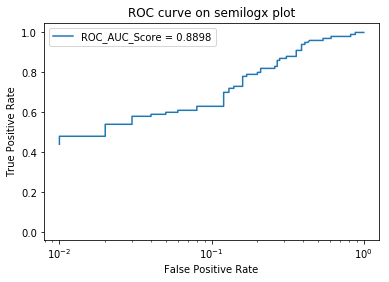

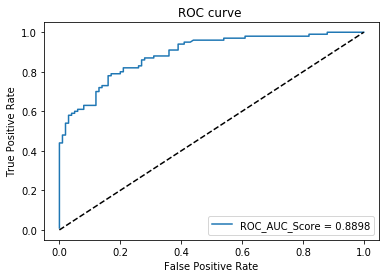

In [10]:
# "randomly select 100 5-char substrings"
ind_frn = np.random.choice(np.arange(len(test_seqs['frn'])), 100, replace=False) 
ind_eng = np.random.choice(np.arange(len(test_seqs['eng'])), 100, replace=False) 

X_test = np.concatenate((np.array(test_seqs['eng'])[ind_eng], np.array(test_seqs['frn'])[ind_frn]))

# "The y_test are 1 for english and 0 for French"
Y_test = np.ones(200)  
Y_test[100:] = 0  

# Computing Probabilities
prob_eng = compute_sum_log_probability(models['eng'], X_test, chars, char_indices, method='m', fill='')
prob_frn = compute_sum_log_probability(models['frn'], X_test, chars, char_indices, method='m', fill='')

# Calculate the Accuracy of the Model
predictions = np.zeros(len(prob_eng))
for i in range(len(prob_eng)):
    if prob_eng[i] > prob_frn[i]:
        predictions[i] = 1  # english predicted
print('Accuracy = {:.2f}%'.format(accuracy_score(Y_test, predictions)*100.0))

# "Plot the ROC on semilogx and print the AUC-ROC on the plot."
prob_eng_np = np.array(prob_eng)
prob_frn_np = np.array(prob_frn)
y_hat = prob_eng_np-prob_frn_np

plot_roc(Y_test, y_hat, semilog=True)
plot_roc(Y_test, y_hat, semilog=False)

## Conclusions

### Is this model good?

Overall, the model performs fairly well considering only 5 epochs were used and the substring inputs were only 5 characters long. Of course, in comparison to a human language detector, getting around 80% accuracy is not very good. However, given the limited amount of data, I was pleasantly surprised with the performance of the LSTM models.

### What are the pros and cons of at least 3 alternative methods of language detection?

1: Hidden Markov Models (source: http://www.lsi.upc.edu/~nlp/papers/padro04a.pdf)

Description - Generates output probabilities based on state transition probabilities learned from observations (similar to method from this project)

Pros - Fast, high levels of precision for both small and large texts

Cons - None that I can think of; this is one of the best language detectors

2: Trigram Frequency Vectors (source: http://www.lsi.upc.edu/~nlp/papers/padro04a.pdf)

Description - Compares relative trigram frequencies between the text and language models

Pros - Easy to understand

Cons - Slower than HMM, bad performance for classifying small texts

3: Word2Vec Clustering

Description - Training Word2Vec on a large text corpus with mixed languages and clustering the resulting word vectors splits different words from different languages into different word clusters, which can be used for language detection

Pros - Effective method for language detection based on word association

Cons - Very slow to generate model, dictionary limited to training corpus, can only be used on words

4: Human Detector

Description - Get someone with knowledge of multiple languages to differentiate the text

Pros - If the person is familiar enough with one or more languages, very high accuracy (~100%)

Cons - Way slower than all previous methods unless the text used for detection is very short


### What are at least 5 ways that this model can be improved?

1: Increase the number of epochs (without overfitting) to tune the model and improve performance

2: Reduce the batch size for better training

3: Increase the amount of training data. This does not always improve the model, but in this case, given the small dataset, it will likely improve performance.

4: Increase the length of text used for detection (i.e. use 40-grams instead of 5-grams). The more detailed the information fed into the model, the better performance

5: Formatting of the text - removing punctuation and unecessary whitespace can help reduce the amount of noise being fed into the model, improving performance

6: Adding more layers to the model. In general, adding layers to NN-based models can improve the effectiveness of the model, although at the cost of speed

# Part 3: Improving the Model (Extra Credit)

## Original Approach

In order to accurately compare the effectiveness of the different models, I expanded the testing set to include all sequences from the testing text.

Accuracy = 78.93%


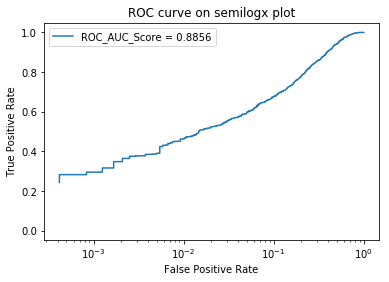

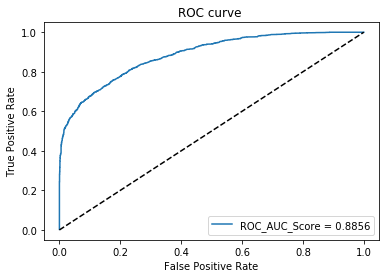

In [11]:
X_test = np.concatenate((np.array(test_seqs['eng']), np.array(test_seqs['frn'])))
Y_test = np.ones(X_test.shape[0])  
Y_test[len(test_seqs['eng']):] = 0 

# Computing Probabilities
prob_eng = compute_sum_log_probability(models['eng'], X_test, chars, char_indices, method='m', fill='')
prob_frn = compute_sum_log_probability(models['frn'], X_test, chars, char_indices, method='m', fill='')

# Calculate the Accuracy of the Model
predictions = np.zeros(len(prob_eng))
for i in range(len(prob_eng)):
    if prob_eng[i] > prob_frn[i]:
        predictions[i] = 1  # english predicted
print('Accuracy = {:.2f}%'.format(accuracy_score(Y_test, predictions)*100.0))

# "Plot the ROC on semilogx and print the AUC-ROC on the plot."
prob_eng_np = np.array(prob_eng)
prob_frn_np = np.array(prob_frn)
y_hat = prob_eng_np-prob_frn_np

plot_roc(Y_test, y_hat, semilog=True)
plot_roc(Y_test, y_hat, semilog=False)

## Sliding Window Approach

While exploring different methods of calculating the log probabilities, we came up with another method that provided greater accuracy results, although at the cost of theoretical viability. Basically, this method involves always looking at the 'n' items before the predicted char.

To give an example, if you wanted to predict P(trump|eng) and the sentence context was 'vote for trump' then, using the english model, you would calculate logP(t|' for ') + logP(r|'for t') + ... + logP(p|' trum'). This way, the input used to generative probabilities never has holes in it, as is the case with the original method used. However, the limitation here is that the probabilities are conditioned upon different terms, and so the mathematically meaning of these calculations is somewhat ambiguous. On the other hand, you are getting a valid probability from the model for each character in the string that you would like to detect, making it a more effective approach in terms of performance.

Here are our results using the same parameters as in Parts 1 and 2.

NOTE: In order to do this approach, you have to collect a bit of extra data, slightly reducing the number of n-grams you can extract from the text. Also this is why there is a '+ 5' when generating sequences from the data in Part 1.

Accuracy = 83.83%


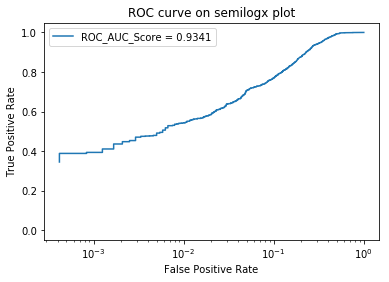

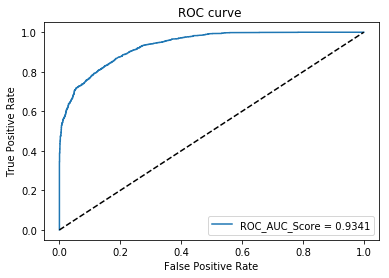

In [12]:
X_test = np.concatenate((np.array(test_seqs['eng']), np.array(test_seqs['frn'])))
Y_test = np.ones(X_test.shape[0])  
Y_test[len(test_seqs['eng']):] = 0 

# Computing Probabilities
prob_eng = compute_sum_log_probability(models['eng'], X_test, chars, char_indices, method='sw', fill='')
prob_frn = compute_sum_log_probability(models['frn'], X_test, chars, char_indices, method='sw', fill='')

# Calculate the Accuracy of the Model
predictions = np.zeros(len(prob_eng))
for i in range(len(prob_eng)):
    if prob_eng[i] > prob_frn[i]:
        predictions[i] = 1  # english predicted
print('Accuracy = {:.2f}%'.format(accuracy_score(Y_test, predictions)*100.0))

# "Plot the ROC on semilogx and print the AUC-ROC on the plot."
prob_eng_np = np.array(prob_eng)
prob_frn_np = np.array(prob_frn)
y_hat = prob_eng_np-prob_frn_np

plot_roc(Y_test, y_hat, semilog=True)
plot_roc(Y_test, y_hat, semilog=False)

## Best Accuracy

In this project, several approaches were discussed for improving the performance of this model. Here, we've applied several of them to get the best results possible (that we know of). Here are the changes made to the original model:

1. Formatting of the text to only include 28 characters (a-z, "'", " ")
2. Increase the size 'n' to 40-gram (note: still predicting for a 5-char substring)
3. Sliding window approach used
4. 20 epochs of training (more epochs led to overfitting)

Accuracy = 87.27%


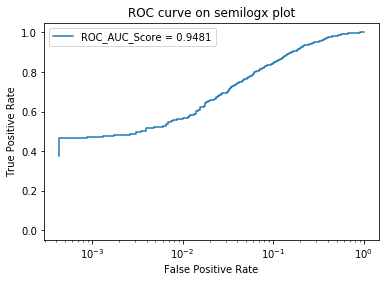

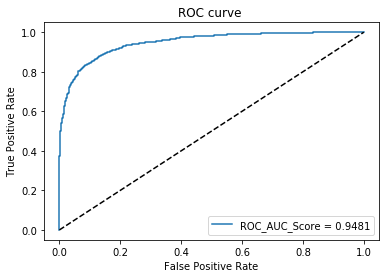

In [13]:
verbose = False # prints additional output
maxlen = 40
num_epochs = 20

# Loading the Data
train_text, test_text, chars, char_indices = load_data(formatting=True) # Note: test_text will be used in next section

# Splitting into N-Grams
train_seqs, train_next_chars = get_sequences(train_text, maxlen, step=step)
test_seqs, test_next_chars = get_sequences(test_text, maxlen+5, step=step) # explanation of +5 in Part 3

# Converting N-Grams to Vectors
X_train, Y_train = get_vectors(train_seqs, chars, char_indices, train_next_chars)

# Building the LSTM Model
models = train_model(X_train, Y_train, chars, printProgress = True, force_train=False)

# "randomly select 100 5-char substrings"
X_test = np.concatenate((np.array(test_seqs['eng']), np.array(test_seqs['frn'])))

# "The y_test are 1 for english and 0 for French"
Y_test = np.ones(X_test.shape[0])  
Y_test[len(test_seqs['eng']):] = 0 

# Computing Probabilities
prob_eng = compute_sum_log_probability(models['eng'], X_test, chars, char_indices, method='sw', maxlen=40)
prob_frn = compute_sum_log_probability(models['frn'], X_test, chars, char_indices, method='sw', maxlen=40)

# Calculate the Accuracy of the Model
predictions = np.zeros(len(prob_eng))
for i in range(len(prob_eng)):
    if prob_eng[i] > prob_frn[i]:
        predictions[i] = 1  # english predicted
print('Accuracy = {:.2f}%'.format(accuracy_score(Y_test, predictions)*100.0))

# "Plot the ROC on semilogx and print the AUC-ROC on the plot."
prob_eng_np = np.array(prob_eng)
prob_frn_np = np.array(prob_frn)
y_hat = prob_eng_np-prob_frn_np

plot_roc(Y_test, y_hat, semilog=True)
plot_roc(Y_test, y_hat, semilog=False)